In [1]:
# libraries

import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Processing and Cleaning

Data Source: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

In [2]:
# read in data
full_df = pd.read_csv('kaggle.csv')

basic cleaning

In [3]:
df = full_df.copy()

# remove number column
df = df.iloc[:, 1:]

# drop rows with null values
df = df.dropna()

In [4]:
print("Dimensions:", df.shape)
df.head(3)

Dimensions: (113999, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


# Visualizations

## Mean Popularity by Genre (Interactive)

In [5]:
# get the mean popularity for each genre — sort highest to lowest
pop_by_genre = df.groupby('track_genre')['popularity'].mean().reset_index().sort_values(by='popularity', ascending=False)

In [6]:
# calculate top 3 songs for each genre - return as a formatted string
def top_3_songs(genre, df):
    songs = df[df['track_genre']==genre].sort_values(by='popularity', ascending=False).head(3)['track_name'].reset_index(drop=True)
    return '; '.join(songs)

# calculate top 3 artists for each genre - return as a formatted string
def top_3_artists(genre, df):
    # instead of going by song, groups by artists and calculates their mean popularity across all applicable songs
    genre_df = df[df['track_genre'] == genre]
    artist_mean_score = genre_df.groupby('artists')['popularity'].mean().sort_values(ascending=False)
    top_artists = artist_mean_score.head(3).index.tolist()
    return '; '.join(top_artists)

In [19]:
# add top 3 songs and top 3 artists to df
pop_by_genre['top_3_songs'] = pop_by_genre['track_genre'].apply(top_3_songs, args=(df,))
pop_by_genre['top_3_artists'] = pop_by_genre['track_genre'].apply(top_3_artists, args=(df,))

In [32]:
pop_by_genre['top_3_songs'][0].split(";").apply(lambda x: 

['Hold On', " I'm Yours", ' Pano']

In [8]:
# use top 10 genres
top_10_genres = pop_by_genre.head(10)

chart = alt.Chart(top_10_genres).mark_bar().encode(
    x=alt.X('track_genre:N', sort='-y', title='Genre'),
    y=alt.Y('popularity:Q', title='Mean Popularity Score'),
    tooltip = [
        alt.Tooltip('track_genre:N', title='Genre'),
        alt.Tooltip('popularity:Q', title='Mean Popularity Score', format='.1f'),
        alt.Tooltip('top_3_songs:N', title='Top 3 Songs'),
        alt.Tooltip('top_3_artists:N', title='Top 3 Artists'),
    ]
).properties(
    width=600,
    height=400,
    title='Mean Popularity Score by Genre (Top 10)'
)

chart

alt.Chart(...)

no - this should be a boxplot. i forgot. also there is the issue of the artists column being a list of artists (artist1; artist2)

the most popular genres being very specific genres makes me think this is not the right method. i also realized that the dataset has an equal amount of songs from each genre. i do not know how they sampled it. but it makes me think that we should focus on genre first. even the dataset description alludes to genre:

"This is a dataset of Spotify tracks over a range of 125 different genres."

## Correlation Matrix

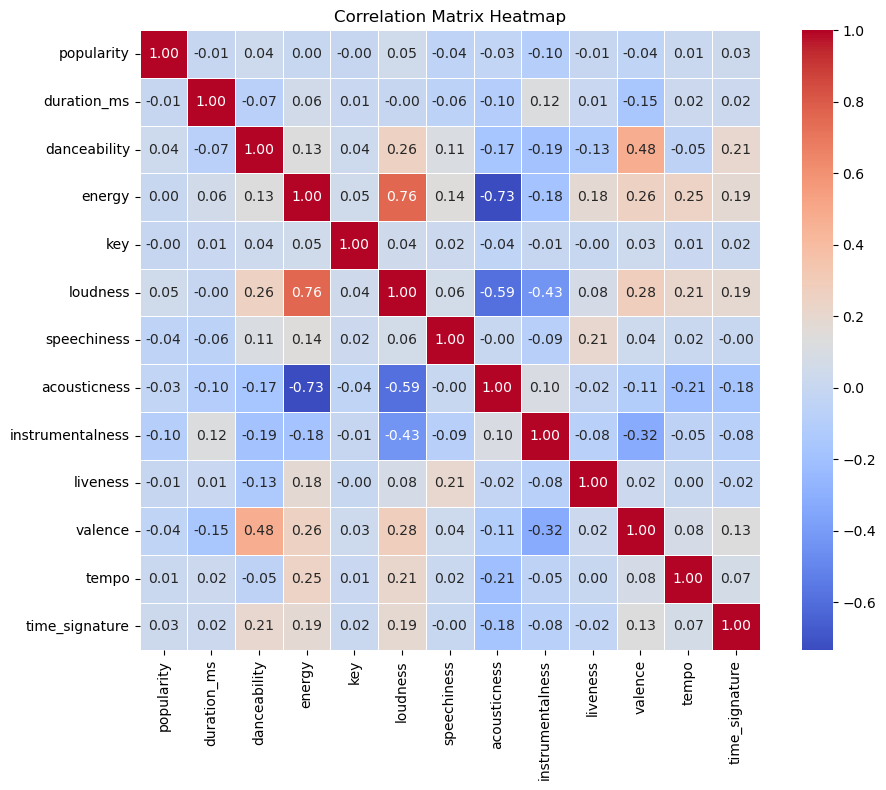

In [9]:
features = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
subset_df = df[features]
corr_matrix = subset_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

shows us some things. like a strong positive correlation between loudness and energy, a strong negative correlation between acousticness and energy, etc. but for the most part, features have little correlation with popularity. not good for our original study question.

## Scatterplot of Feature vs. Popularity

i had an idea now which was filtering the data further. so filtering to only the popular songs (score >= 70) and to commonly popular genres (genres that had many songs with popularity scores above the threshold). this seems to work in subsetting to genres that are traditionally considered popular like pop and dance and whatnot.

In [10]:
# only songs with a score above 70
df = df[df['popularity'] >= 70]

In [11]:
# keep only genres that appear at least 10 times
genre_counts = df['track_genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 150].index

df_filtered = df[df['track_genre'].isin(valid_genres)]

In [12]:
df_filtered['track_genre'].value_counts()

track_genre
pop            317
dance          245
electro        241
k-pop          225
house          221
metal          217
rock           198
indie          185
edm            182
indie-pop      177
latino         174
alternative    168
alt-rock       166
reggaeton      158
Name: count, dtype: int64

In [13]:
popular_genres = list(df_filtered['track_genre'].unique())
# how many unique genres after filtering
print(len(popular_genres))

14


In [14]:
df_filtered.shape

(2874, 20)

loudness and energy selected here due to a strong correlation in the previous heatmap. could be any two variables, really.

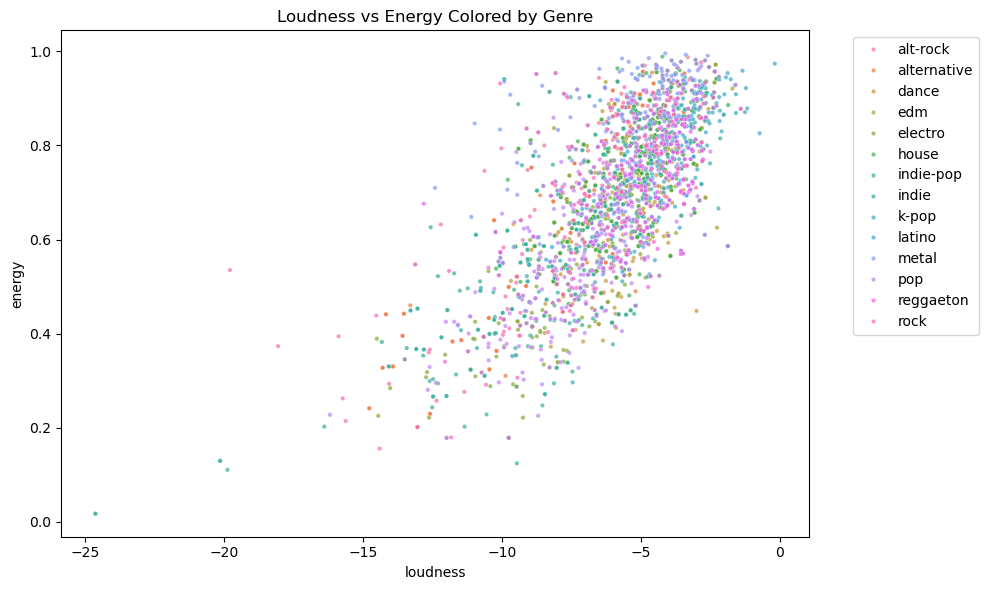

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='loudness', y='energy', hue='track_genre', s=10, alpha=0.7, legend='full')
plt.title('Loudness vs Energy Colored by Genre')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

same exact thing but in altair and made interactive

In [16]:
# point selection upon clicking
pointselection = alt.selection_point(
    fields=["track_genre"],
    on="click",
    empty=True
)

# scatterplot
scatter = alt.Chart(df_filtered).mark_circle(size=50).encode(
    x=alt.X('loudness', title='Loudness'),
    y=alt.Y('energy', title='Energy'),
    color=alt.condition(pointselection, 'track_genre:N', alt.value('lightgray')),
    tooltip=['track_genre']
).add_params(
    pointselection
).properties(
    width=600,
    height=400,
    title='Loudness vs. Energy Colored by Genre'
)

scatter

alt.Chart(...)

interaction: user can click to view distribution for each genre. ideally this could be changed so the user could click on a genre from the legend too and not just from the plot which is a little difficult. also could allow the user to set the popularity score threshold themself and filter the data like that (like how homework4 filtered by max population).

In [17]:
features2 = ['popularity', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'valence'] # shortened list of features

# mean feature values for each genre. popularity converted to fit on 0-1 scale
genre_feature_means = df_filtered.groupby('track_genre')[features2].mean().reset_index()
genre_feature_means['popularity'] = genre_feature_means['popularity']/100

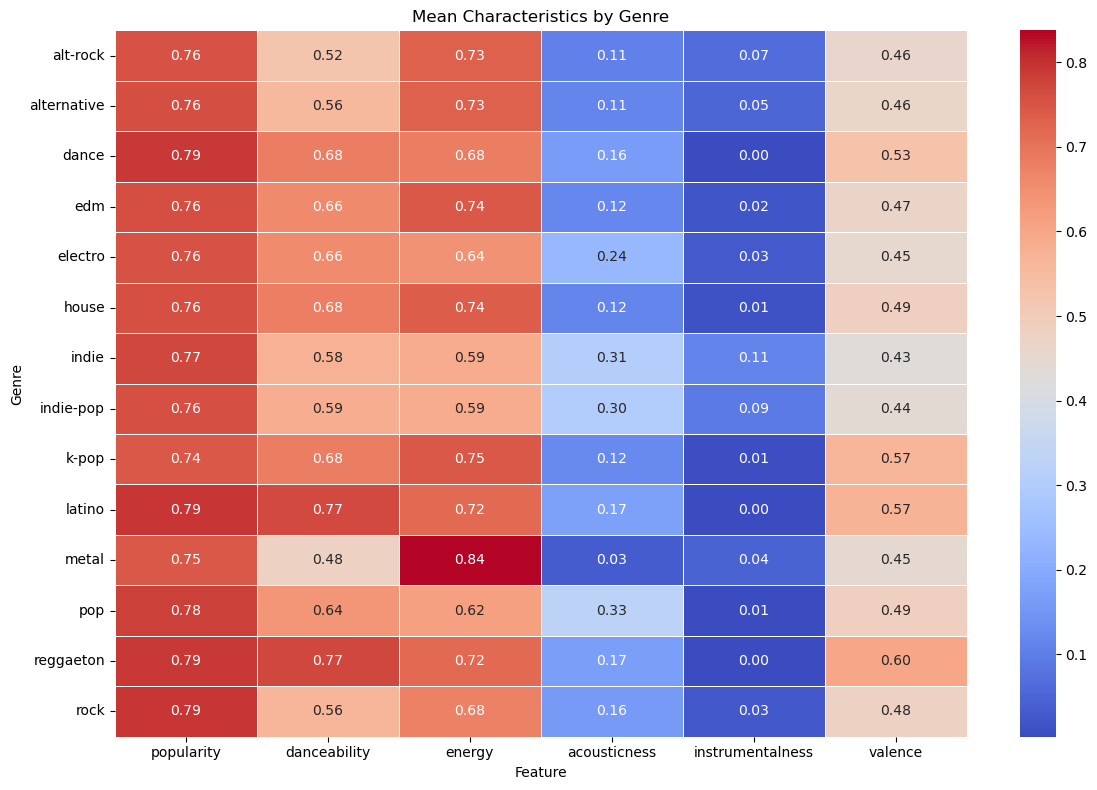

In [18]:
# set genre as index for heatmap
heatmap_data = genre_feature_means.set_index('track_genre')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Mean Characteristics by Genre")
plt.ylabel("Genre")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

i think this is useful in seeing what characteristics genres have. for example metal with low danceability and high energy. 

also tells you about what may contribute to popularity. like low instrumentalness score. 

here is what i'm thinking. instead of focusing on only what characteristics impact popularity (which may not be great because there's low correlation), we can investigate (1) what characteristics define (popular) genres and then (2) how those characteristics and different genres impact popularity if at all

i do think the filtering to most popular songs and genres helps

possible visualizations:

- heatmap of mean characteristics by genre (like the figure right above) - static, python (or D3? idk what D3 is capable of)
- scatterplot colored by genre (like the one two figures above) - interactive, altair
- box plots of popularity by genre (similar to the wip mean popularity score bar plots w/ hoverable info) - interactive, altair
- correlation heatmap btwn features to show correlation with popularity - static, python or D3
- one or two more... need another interactive figure i think unless the scatterplot can have multiple interactions (if that counts)